In [151]:
import xlwings as xw
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import difflib
import platform
import openai
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
file_path = './data/data.xlsb'
wb = xw.Book(file_path)
rng = wb.sheets[3].used_range

In [3]:
def parse_cells_win(rng):
    pass

def parse_cells_mac(rng):
    pass

def parse_cells(rng):
    print(platform.system())
    if platform.system() == 'Windows':
        return parse_cells_win(rng)
    elif platform.system() == 'Darwin':
        return parse_cells_mac(rng)
    else:
        raise Exception('Unsupported platform')

parse_cells(rng)

Darwin


In [227]:
def parse_cell(cell):
    return {
        'address': cell.address,
        'value': cell.value,
        'formula': cell.formula,
        'format': cell.number_format,
        'color': cell.color,
        'font': {
            'name': cell.font.name,
            'emphasis': cell.font.bold,
            'size': cell.font.size
        }
    }

cells = [[parse_cell(cell) for cell in row] for row in rng.rows]

In [5]:
def merge_mask(cells, key=lambda x: x['value'], cmp=lambda x, y: x == y):
    """Group via RD DFS on cmp(key1, key2) = true"""
    st = []
    mask = [[-1 for c in r] for r in cells]

    def push(rt, nb):
        if cmp(key(cells[rt[0]][rt[1]]), key(cells[nb[0]][nb[1]])):
            if mask[nb[0]][nb[1]] == -1: # not visited
                st.append(nb)

    def dfs(rt, cat):
        if mask[rt[0]][rt[1]] >= 0: return # alr. visited

        st.append(rt)

        while len(st) > 0:
            s = st.pop()
            r, c = s
            mask[r][c] = cat

            if r < len(cells)-1:
                push(s, (r+1, c))
            
            if c < len(cells[0])-1:
                push(s, (r, c+1))

    cat = 1
    for r, row in enumerate(cells):
        for c, cell in enumerate(row):
            if mask[r][c] >= 0: continue

            if key(cell) is not None:
                dfs((r, c), cat)
                cat += 1
            else:
                mask[r][c] = 0 # empty

    return np.array(mask)

In [110]:
def region_to_ranges(region: np.array):
    def get_runs(r):
        runs = []
        for j in range(region.shape[1]):
            if region[r][j] > 0:
                if len(runs) > 0 and runs[-1][1] == j-1:
                    runs[-1][1] = j
                else:
                    runs.append([j, j])
        
        return runs
    
    def extend_run(r, run):
        er = r
        for j in range(r+1, region.shape[0]):
            if np.all(region[j][run[0]:run[1]+1] > 0):
                region[j][run[0]:run[1]+1] = 0
                er = j
            else: break
        
        return ((r, run[0]), (er, run[1]))

    rngs = []
    for r in range(region.shape[0]):
        runs = get_runs(r)
        for run in runs:
            rng = extend_run(r, run)
            rngs.append(rng)

    return rngs

def mask_to_ranges(cells, mask, key):
    n = np.max(mask)
    regions = []
    for t in range(1, n+1):
        ind = np.unravel_index(np.argmax(mask == t), mask.shape)
        val = key(cells[ind[0]][ind[1]])
        rs = region_to_ranges(mask == t)

        sm = np.sum(mask == t)
        check = 0
        for r in rs:
            a = (r[1][0] - r[0][0] + 1) * (r[1][1] - r[0][1] + 1)
            check += a
        # print(t, sm, check, rs)
        assert(sm == check)
        
        region = {
            'val': val,
            'ranges': rs
        }

        regions.append(region)

    return regions

        

In [231]:
def excel_col_to_num(col):
    if not col.isalpha(): return False

    return sum((ord(c) - ord('A') + 1) * (26 ** (len(col) - i - 1)) for i, c in enumerate(col))

def num_to_excel_col(num):
    col = ''
    while num > 0:
        num, rem = divmod(num, 26)
        if rem == 0:
            col = 'Z' + col
            num -= 1
        else:
            col = chr(ord('A') + rem - 1) + col
    return col

def coord_to_address(r, c):
    return f'${num_to_excel_col(c+1)}${r+1}'

def address_to_coord(addr):
    cola = ''.join(c for c in addr if c.isalpha())
    row = ''.join(c for c in addr if c.isdigit())
    col = excel_col_to_num(cola)
    row = int(row)
    return row-1, col-1


In [232]:
def get_regions(cells, key=lambda x: x['value'], cmp=lambda x, y: x == y):
    mask = merge_mask(cells, key=key, cmp=cmp)
    regions = mask_to_ranges(cells, mask, key)
    
    row, col = address_to_coord(cells[0][0]['address'])
    
    for i, region in enumerate(regions):
        ranges = [':'.join([coord_to_address(x[0] + row, x[1] + col) for x in r]) for r in regions[i]['ranges']]
        regions[i] = {
            'val': region['val'],
            'ranges': ranges
        }
        
    return regions

In [233]:
def value_key(x):
    return None if x['value'] is None else 1

def formula_cmp(x, y):
    if x == y: return True
    if x is None or y is None: return False
    
    diff = [(i, s) for i, s in enumerate(difflib.ndiff(x, y)) if s[0] in ['-', '+']]
    gdiff = []
    for d in diff:
        join = True
        if len(gdiff) == 0:
            join = False
        else:
            if gdiff[-1]['type'] != d[1][0] or abs(gdiff[-1]['ind'] - d[0]) > 1:
                join = False

        if join: 
            gdiff[-1]['value'] += d[1][-1]
        else:
            gdiff.append({'type': d[1][0], 'ind': d[0], 'value': d[1][-1]})

    similar = 0
    for i, d in enumerate(gdiff):
        if d['type'] == '-' and i < len(gdiff)-1 and gdiff[i+1]['type'] == '+':
            a, b = d['value'], gdiff[i+1]['value']
            if a.isdigit() and b.isdigit(): # consec row ref
                a, b = int(a), int(b)
                if abs(a - b) == 1:
                    similar += 1
            elif a.isalpha() and b.isalpha(): # consec col ref
                if abs(excel_col_to_num(a) - excel_col_to_num(b)) == 1:
                    similar += 1
    
    if similar > (len(gdiff)//2) * 0.9: return True # 0.9 for fuzziness

    return False

def formula_key(x):
    s = x['formula'].strip()
    return s if len(s) > 0 else None

def format_key(x):
    s = x['format']
    return None if s == 'General' else s

def color_key(x):
    col = x['color']
    if col is None: return None
    r, g, b = col
    return f'#{r:02x}{g:02x}{b:02x}'

def font_key(x):
    f = x['font']
    return f'{f["name"]}-{f["size"]}-{f["emphasis"]}'

In [234]:
value_rgs = get_regions(cells, key=value_key)
color_rgs = get_regions(cells, key=color_key)
font_rgs = get_regions(cells, key=font_key)
format_rgs = get_regions(cells, key=format_key)
formula_rgs = get_regions(cells, key=formula_key, cmp=formula_cmp)

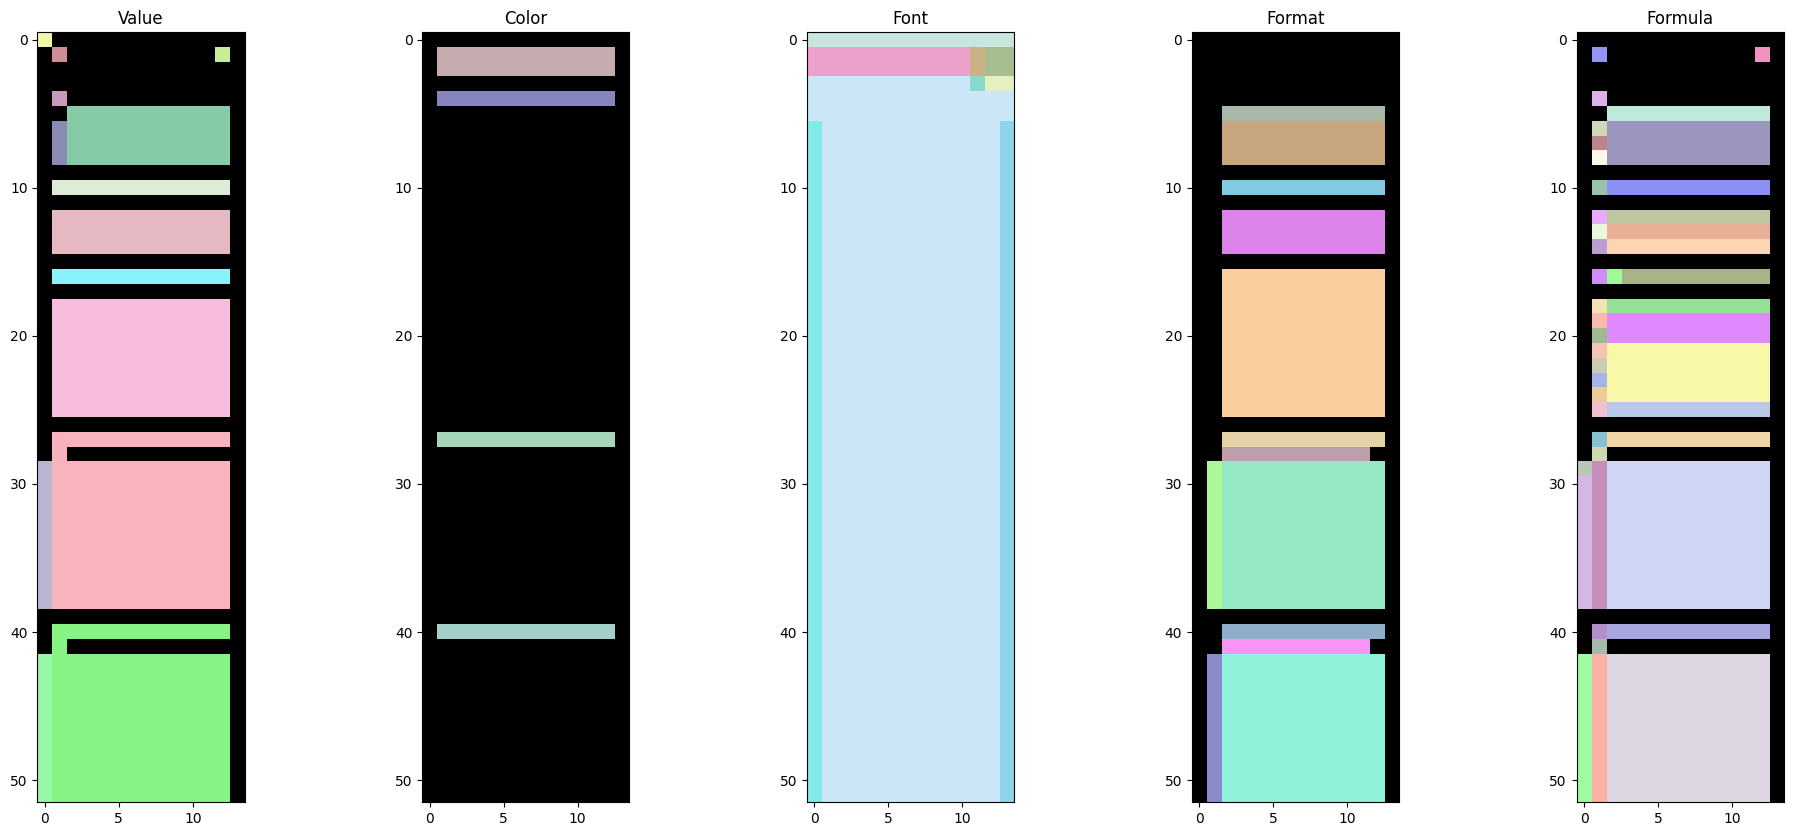

In [235]:
def plot_rgs(rngs: dict, shape, title, ax):
    mask = np.zeros(shape)
    
    # Assign random color to each range
    for i, region in enumerate(rngs):
        for rng in region['ranges']:
            st, end = rng.split(':')
            (r1, c1), (r2, c2) = address_to_coord(st), address_to_coord(end)
            mask[r1:r2+1, c1:c2+1] = i+1

    # Convert mask to colored image
    num_categories = int(mask.max())
    colors = np.zeros((num_categories + 1, 3))
    colors[1:] = np.random.random((num_categories, 3))*0.5+0.5  # Random RGB values for categories 1+
    
    colored_mask = colors[mask.astype(int)]
    
    ax.imshow(colored_mask)
    ax.set_title(title)
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24,10))
shape = (len(cells), len(cells[0]))
plot_rgs(value_rgs, shape, 'Value', ax1)
plot_rgs(color_rgs, shape, 'Color', ax2)
plot_rgs(font_rgs, shape, 'Font', ax3)
plot_rgs(format_rgs, shape, 'Format', ax4)
plot_rgs(formula_rgs, shape, 'Formula', ax5)

plt.show()


In [236]:
def encode_attribute(rgs):
    def encode_region(rg):
        return f'(`{rg["val"]}` ; [{", ".join(rg["ranges"])}])'

    s = '\n'.join([encode_region(rg) for rg in rgs])
    return s

encode_attribute(value_rgs)

'(`1` ; [$A$1:$A$1])\n(`1` ; [$B$2:$B$2])\n(`1` ; [$M$2:$M$2])\n(`1` ; [$B$5:$B$5])\n(`1` ; [$C$6:$M$9])\n(`1` ; [$B$7:$B$9])\n(`1` ; [$B$11:$M$11])\n(`1` ; [$B$13:$M$15])\n(`1` ; [$B$17:$M$17])\n(`1` ; [$B$19:$M$26])\n(`1` ; [$B$28:$M$28, $B$29:$B$39, $C$30:$M$39])\n(`1` ; [$A$30:$A$39])\n(`1` ; [$B$41:$M$41, $B$42:$B$52, $C$43:$M$52])\n(`1` ; [$A$43:$A$52])'

In [237]:
# 1. Get e2e deliverable to work
#     - Table detection
#         * GPT to detect headers first
#         * Send header data and ask for a list of tables, each table has a data range + row label range + column label range 
#         * Validate dimensions matching. Store the headers and the tables. 

# What does the prompt look like for getting the headers?

In [238]:
header_prompt_template = """You are a table detection expert. You are given information describing the structure of an Excel spreadsheet. Your task is to output Excel ranges corresponding to the headers. 

The input contains 5 structural attributes: "Value", "Color", "Font", "Format", "Formula". For each *attribute*, you will be given a newline separated list of regions.
A region represents a contiguous region of spreadsheet cells that have nearly the same attribute value.
Each region is specified as a semicolon-separated tuple of the value of the attribute as a backtick-quoted string along with a comma-separated list of Excel ranges whose union is the region e.g. (`value` ; ['A1:B3', 'C1:D3']).
Ranges are specified like 'A1:B3' which selections the first to second row and first to third column, inclusive. 

The Value attribute is 1 if the cell has a value, 0 otherwise. A formula region contain cells whose formula only differs from the region value by cell reference changes, common when applying a formula to a range of cells. 

Your task is to output a comma separated list, surrounded by [], of non-overlapping Excel ranges e.g. 'A1:B3' corresponding to the header regions of the data. An overestimate is preferred to an underestimate. You should select any regions that may contain information for describing the data, but you should omit regions that contain the data itself.
DO NOT ADD OTHER WORDS OR EXPLANATION.

INPUT:
*Value*
{}

*Color*
{}

*Font*
{}

*Format*
{}

*Formula*
{}
"""

header_prompt = header_prompt_template.format(
    encode_attribute(value_rgs),
    encode_attribute(color_rgs),
    encode_attribute(font_rgs),
    encode_attribute(format_rgs),
    encode_attribute(formula_rgs)
)

In [ ]:
client = openai.OpenAI()
# model = "o4-mini-2025-04-16"
model = 'gpt-4.1'
header_response = client.responses.create(
  model=model,
  input=[
      {
          "role": "user",
          "content": header_prompt
      }
  ]
)

In [ ]:
print("Input tokens per cell", header_response.usage.input_tokens / (shape[0]*shape[1]))

query_chars = sum([
    len(encode_attribute(x)) for x in [value_rgs, color_rgs, font_rgs, format_rgs, formula_rgs]
])
print("Input chars per cell", query_chars / (shape[0]*shape[1]))


Input tokens per cell 2.92032967032967
Input chars per cell 4.802197802197802


In [ ]:
def parse_ranges_response(s:str):
    s = [r.strip() for r in s.strip('[]').split(',')]
    return s

info_ranges = parse_ranges_response(header_response.output_text)

def get_values_in_range(rng:str):
    def format_value(c):
        v = c['value']
        if v is None:
            return ''
        else: return str(v)

    st, end = rng.split(':')
    (r1, c1), (r2, c2) = address_to_coord(st), address_to_coord(end)
    data = []
    for r in range(r1, r2+1):
        data.extend([format_value(v) for v in cells[r][c1:c2+1]])
    
    return data

header_data = {rng: '[' + ', '.join(get_values_in_range(rng)) + ']' for rng in info_ranges}

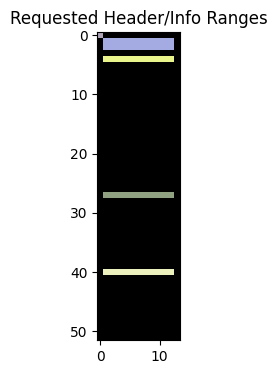

In [246]:
def plot_ranges(rngs: dict, shape, title, ax):
    mask = np.zeros(shape)
    
    for i, rng in enumerate(rngs):
        st, end = rng.split(':')
        (r1, c1), (r2, c2) = address_to_coord(st), address_to_coord(end)
        mask[r1:r2+1, c1:c2+1] = i+1

    # Convert mask to colored image
    num_categories = len(rngs)
    colors = np.zeros((num_categories + 1, 3))
    colors[1:] = np.random.random((num_categories, 3))*0.5+0.5  # Random RGB values for categories 1+
    
    colored_mask = colors[mask.astype(int)]
    
    ax.imshow(colored_mask)
    ax.set_title(title)
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
plot_ranges(info_ranges, shape, 'Requested Header/Info Ranges', ax1)
plt.show()

In [ ]:
table_detection_template = """
You are now given the data corresponding to the header/informative regions that you outputted in your previous response.
The ranges are newline separated. For each range, you are given the range, a space, and a comma separated list of backtick-quoted cell values in row-major order where e.g. A1:A3 [`value1`, , `value2`] implies that the second cell is empty. 

Using this information and the previous attribute region information, your task is to detect every table present in the spreadsheet.
You should output a semicolon-separated list of tables. For each table, you should give a comma-separated, parenthesized tuple of three ranges: the data range, the row header range, and the column header range. If either of these headers are blank, you should leave it blank in the tuple: e.g. (A2:D7, A2:D2, ) specifies a blank column header. 

DO NOT ADD OTHER WORDS OR EXPLANATION.

INPUT:
{}
"""

header_data_input = '\n'.join([f'{h[0].replace('$', '')} {h[1]}' for h in header_data.items()])
table_detection_prompt = table_detection_template.format(header_data_input)

'\nYou are now given the data corresponding to the header/informative regions that you outputted in your previous response.\nThe ranges are newline separated. For each range, you are given the range, a space, and a comma separated list of backtick-quoted cell values in row-major order where e.g. A1:A3 [`value1`, , `value2`] implies that the second cell is empty. \n\nUsing this information and the previous attribute region information, your task is to detect every table present in the spreadsheet.\nYou should output a semicolon-separated list of tables. For each table, you should give a comma-separated, parenthesized tuple of three ranges: the data range, the row header range, and the column header range. If either of these headers are blank, you should leave it blank in the tuple: e.g. (A2:D7, A2:D2, ) specifies a blank column header. \n\nDO NOT ADD OTHER WORDS OR EXPLANATION.\n\nINPUT:\nA1:A1 [   ]\nB2:M3 [IRR MATRIX, , , , , , , , , , , BIG RED BUILDING, , , , , , , , , , , , ]\nB5:M

In [ ]:
response = client.responses.create(
  model=model,
  previous_response_id=header_response.id,
  input=[
      {
          "role": "user",
          "content": table_detection_prompt
      }
  ]
)

In [259]:
def parse_table_detection_response(s:str):
    s = [r.strip('() ').split(',') for r in s.strip().split(';')]
    s = [{'data': r[0], 'row_hdr': r[1].strip(), 'col_hdr': r[2].strip()} for r in s]
    return s

tables = parse_table_detection_response(response.output_text)
tables

[{'data': 'C6:M9', 'row_hdr': 'B5:B9', 'col_hdr': 'C5:M5'},
 {'data': 'C30:M39', 'row_hdr': 'B28:B39', 'col_hdr': 'C28:M28'},
 {'data': 'C43:M52', 'row_hdr': 'B41:B52', 'col_hdr': 'C41:M41'}]

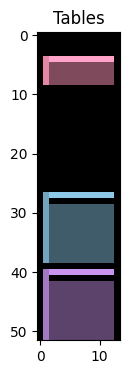

In [275]:
def plot_tables(tables:list, shape, title, ax):
    colored_mask = np.zeros((*shape, 3))

    def color_range(rng:str, col):
        st, end = rng.split(':')
        (r1, c1), (r2, c2) = address_to_coord(st), address_to_coord(end)
        colored_mask[r1:r2+1, c1:c2+1, :] = col

    for i, table in enumerate(tables):
        col = np.random.random(3)*0.5+0.5
        color_range(table['data'], col*0.5)
        color_range(table['row_hdr'], col*0.9)
        color_range(table['col_hdr'], col*1.1)
    
    colored_mask = np.clip(colored_mask, 0, 1)
    ax.imshow(colored_mask)
    ax.set_title(title)
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
plot_tables(tables, shape, 'Tables', ax1)
plt.show()